# Data Exploration

**Description**: https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries

**Goal**: Predict how popular an apartment rental listing is based on the listing content like text description, photos, number of bedrooms, price, etc. The data comes from renthop.com, an apartment listing website. These apartments are located in New York City.

**Target variable**: interest_level, it is defined by the number of inquiries a listing has in the duration that the listing was live on the site.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import string
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from nltk import word_tokenize
from nltk.collocations import *
from nltk.corpus import stopwords
from nltk.util import bigrams, ngrams

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
pd.set_option('display.max_rows', 500)    # #columns to display
pd.set_option('display.max_colwidth', -1) # show all the text strings in the column

#color = sns.color_palette()
#sns.palplot(sns.color_palette('colorblind'))
sns.set_palette('dark')

%matplotlib inline

In [3]:
train_df = pd.read_json('train.json').reset_index(drop=True)
test_df = pd.read_json('test.json').reset_index(drop=True)

In [4]:
train_df.shape, test_df.shape

((49352, 15), (74659, 14))

In [5]:
train_df['test'] = False
test_df['test'] = True

df = train_df.append(test_df).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124011 entries, 0 to 124010
Data columns (total 16 columns):
bathrooms          124011 non-null float64
bedrooms           124011 non-null int64
building_id        124011 non-null object
created            124011 non-null object
description        124011 non-null object
display_address    124011 non-null object
features           124011 non-null object
interest_level     49352 non-null object
latitude           124011 non-null float64
listing_id         124011 non-null int64
longitude          124011 non-null float64
manager_id         124011 non-null object
photos             124011 non-null object
price              124011 non-null int64
street_address     124011 non-null object
test               124011 non-null bool
dtypes: bool(1), float64(3), int64(3), object(9)
memory usage: 14.3+ MB


In [6]:
df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,test
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy These Following Apartment Features As You Rent Here? Modern Designed Bathroom w/ a Deep Spa Soaking Tub? Room to Room AC/Heat? Real Oak Hardwood Floors? Rain Forest Shower Head? SS steel Appliances w/ Chef Gas Cook Oven & LG Fridge? washer /dryer in the apt? Cable Internet Ready? Granite Counter Top Kitchen w/ lot of cabinet storage spaceIt's Just A Few blocks To L Train<br /><br />Don't miss out!<br /><br />We have several great apartments in the immediate area.<br /><br />For additional information 687-878-2229<p><a website_redacted,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,"[https://photos.renthop.com/2/7211212_1ed4542ec81621d70d1061aa833e669c.jpg, https://photos.renthop.com/2/7211212_7dfc41dced69245065df83d08eed4a00.jpg, https://photos.renthop.com/2/7211212_c17853c4b869af6f53af08b0f5820b4c.jpg, https://photos.renthop.com/2/7211212_787ad8ea0c089792e7453e2121f8ac89.jpg, https://photos.renthop.com/2/7211212_2e88b0d293ee333c804c2f00536eee49.jpg]",3000,792 Metropolitan Avenue,False
1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allowed, Dogs Allowed]",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,"[https://photos.renthop.com/2/7150865_be3306c5d89c6bfa755c6e89c9ed64d5.jpg, https://photos.renthop.com/2/7150865_655f861a1d5da70050010611016ae2ad.jpg, https://photos.renthop.com/2/7150865_5b8cc459f3abd38bc81cbf329dab3220.jpg, https://photos.renthop.com/2/7150865_2f59c34ca4ea98c26d559109a467ef84.jpg, https://photos.renthop.com/2/7150865_2258d2eb5b5fb4bc0eb6534929cdee15.jpg, https://photos.renthop.com/2/7150865_af28a5075bd321e694791645423dcdde.jpg, https://photos.renthop.com/2/7150865_714a3d63488162ebe4a22896dd5138f7.jpg, https://photos.renthop.com/2/7150865_8dda0ecbe4c6015d3e8dffe16808aa0b.jpg, https://photos.renthop.com/2/7150865_c4aabf346e295afda87d13c16f6f5659.jpg, https://photos.renthop.com/2/7150865_2de68908ea943dd96c925490c7f98297.jpg, https://photos.renthop.com/2/7150865_fc18c2e84683b567c9568ed7597f1ba8.jpg]",5465,808 Columbus Avenue,False
2,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-war building with laundry in the basement and live in super!<br/><br/>Apartment features a large bedroom with closet. Separate living room, kitchen features granite tops, dishwasher and microwave included, marble bathroom and hardwood flooring. Building is very well maintained and conveniently located near A,C,E,L,1,2,3 trains. Surrounded by many local cafe?s, restaurants, available for November 1st move in!<br/><br/>To view this apartment or any other please contact me via email or call at the number listed.<br/><br/><br/><br/><br/><br/>Bond New York is a real estate broker that supports equal housing opportunity.<p><a website_redacted",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Floors, Pets Allowed Case by Case]",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,"[https://photos.renthop.com/2/6887163_de85c427363a2e6d736a5df96d8d5541.jpg, https://photos.renthop.com/2/6887163_b9cf6db6df611bc53f75be3214a43807.jpg, https://photos.renthop.com/2/6887163_cd3f2246cfd25691f33ed12b251d0230.jpg, https://photos.renthop.com/2/6887163_54c402cf0d681f6ea4796b9d177786bb.jpg, https://photos.renthop.com/2/6887163_7745da2a3693fe627154794ab0ebca29.jpg, https://photos.renthop.com/2/6887163_95c93e4af27182f8ac55c749fc74a041.jpg, https://photos.renthop.com/2/6887163_4b50a743b760e23b8d6f6f586a704da7.jpg, https://photos.renthop.com/2/6887163_6133523d6d5a0fba36bb25e3616848c8.jpg]",2850,241 W 13 Street,False


In [7]:
pd.options.display.float_format = '{:,.0f}'.format
#pd.set_option('display.precision', 2)
df.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,"124,011","124,011","124,011","124,011","124,011","124,011"
mean,1,2,41,"7,024,022",-74,"3,781"
std,1,1,1,"126,380",1,"15,830"
min,0,0,0,"6,811,957",-121,1
25%,1,1,41,"6,915,638",-74,"2,495"
50%,1,1,41,"7,021,451",-74,"3,150"
75%,1,2,41,"7,129,028",-74,"4,100"
max,112,8,45,"7,761,779",0,"4,490,000"


In [8]:
df[(df.bathrooms==112) | (df.price == 1) | (df.price==4490000)]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,test
19558,1,2,cd25bbea2af848ebe9821da820b725da,2016-06-24 05:02:11,,Hudson Street,"[Doorman, Elevator, Cats Allowed, Dogs Allowed, Exclusive]",low,41,7208764,-74,d1737922fe92ccb0dc37ba85589e6415,[],4490000,421 Hudson Street,False
69023,112,3,33fa7be8ea2ffc6353af117cab78f569,2016-06-07 05:22:55,"This is a pretty, charming, prime location 3 bedrooms apartment, with large windows, hardwood floors living room and bedrooms. The kitchen has an ample breakfast bar, all in white appliances and enough amount of cabinets. The bathrooms owns a very neat and clean aspect with all in white ceramic tiles and floor. One of a kind opportunity. Call us for a viewing.AH<br /><br /><p><a website_redacted",East 75th Street,[Hardwood Floors],NaN,41,7120577,-74,3e1edc05ca35eaecc90766629d22d078,"[https://photos.renthop.com/2/7120577_dea70af49f689356390e08b7e87b7147.jpg, https://photos.renthop.com/2/7120577_1879301659a01b98208ec014dacbc55d.jpg, https://photos.renthop.com/2/7120577_76e9ee0c957ab8ea9ba10c2a12e41cea.jpg, https://photos.renthop.com/2/7120577_5d3068c109a5277d55593ab1cd528e2f.jpg, https://photos.renthop.com/2/7120577_37b33d72876bf14affd34cd81368eaac.jpg]",3700,433 East 75th Street,True
87120,1,2,0,2016-05-23 18:06:47,Stay in control of your rental\rSeal is the best way to manage leasing agreements to ensuring payment and transparency for renter and rent-ee. Find out more here:\r\r website_redacted,140 West Street,[http://sealagreements.com/leasing/],NaN,41,7056147,-74,b8db1eaabe00c9cc383a146a4748feb6,[https://photos.renthop.com/2/7056147_0594c8874485c3590a69b3a8a8b03394.jpg],1,140 West Street,True


In [9]:
df.isnull().sum(axis = 0) # no missing df

bathrooms          0    
bedrooms           0    
building_id        0    
created            0    
description        0    
display_address    0    
features           0    
interest_level     74659
latitude           0    
listing_id         0    
longitude          0    
manager_id         0    
photos             0    
price              0    
street_address     0    
test               0    
dtype: int64

In [10]:
print 'Min: ', df.created.min()
print 'Max: ', df.created.max()

Min:  2016-04-01 22:12:41
Max:  2016-06-29 21:55:35


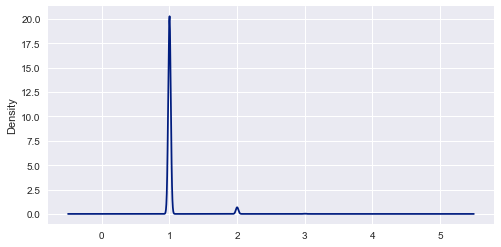

In [11]:
df['created'] = pd.to_datetime(df.created)
df.created.value_counts().sort_index().plot(kind='density', figsize=(8,4))

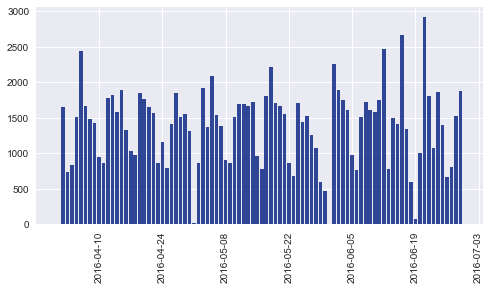

In [12]:
plt.figure(figsize=(8, 4))
plt.bar(df.created.dt.date.value_counts().index, df.created.dt.date.value_counts().values, alpha=0.8)
plt.xticks(rotation='vertical')
plt.show()

## Numeric variables

### Bathrooms and Bedrooms

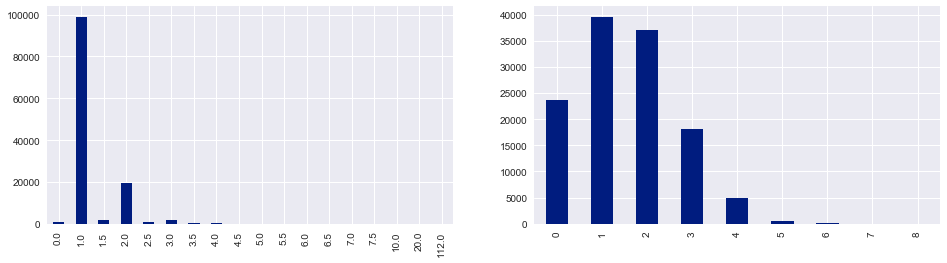

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

df.bathrooms.value_counts().sort_index().plot(kind='bar', ax=axes[0])
df.bedrooms.value_counts().sort_index().plot(kind='bar', ax=axes[1])

We may use a treshold for #bedrooms/bathrooms to remove the outliners.

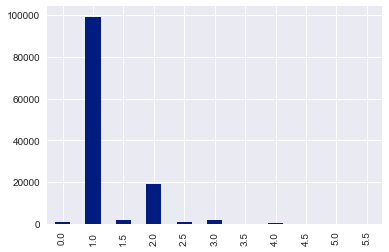

In [14]:
df.bathrooms.where(df.bathrooms < 6).value_counts().sort_index().plot(kind='bar')

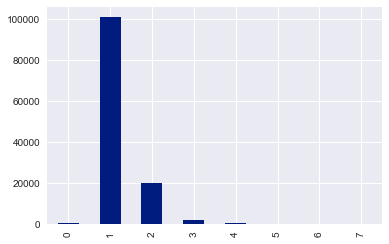

In [15]:
#df.loc[df.bathrooms >= 6] = 0
df.bathrooms = df.bathrooms.map(lambda b: b if b < 10 else 0)
df.bathrooms.astype(int).value_counts().sort_index().plot(kind='bar')

In [16]:
df['bb_combined'] = df.bathrooms + df.bedrooms
df['price_per_room'] = df.price / df.bedrooms  
df['price_per_bath'] = df.price / df.bathrooms

### Latitude and Longitude

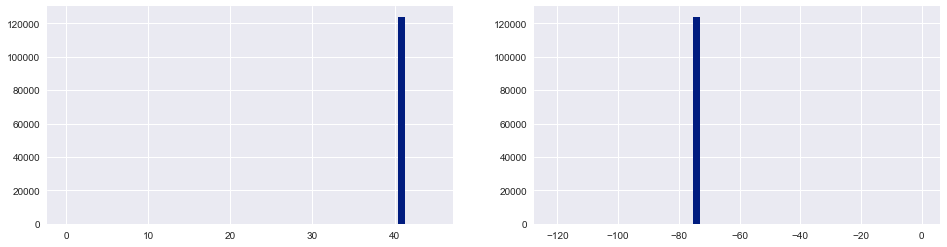

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

df.latitude.hist(bins = 50, ax=axes[0])
df.longitude.hist(bins = 50, ax=axes[1])

There are some outliners. Let's move them to the center.

In [18]:
(lat_min, lat_max), lat_mean = np.percentile(df.latitude, [1, 99]).tolist(), np.mean(df.latitude)
(lon_min, lon_max), lon_mean = np.percentile(df.longitude, [1, 99]).tolist(), np.mean(df.longitude)
print "For latitude min/max/mean: %s, %s, %s " % (lat_min, lat_max, lat_mean)
print "For longitude min/max/mean: %s, %s, %s " % (lon_min, lon_max, lon_mean)

df.latitude = np.where(df.latitude < lat_min, lat_mean, df.latitude)
df.latitude = np.where(df.latitude > lat_max, lat_mean, df.latitude)

df.longitude = np.where(df.longitude < lon_min, lon_mean, df.longitude)
df.longitude = np.where(df.longitude > lon_max, lon_mean, df.longitude)

For latitude min/max/mean: 40.63981, 40.8614, 40.7376406811 
For longitude min/max/mean: -74.0162, -73.8507, -73.9494341187 


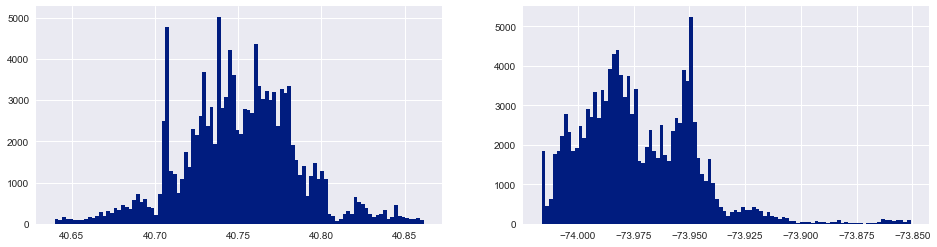

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

df.latitude.hist(bins = 100, ax=axes[0])
df.longitude.hist(bins = 100, ax=axes[1])

### Price

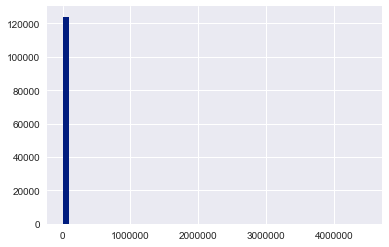

In [20]:
df.price.hist(bins = 50)

Definitely there are some outliners, we could repeat the same trick as we did for lat/lon, but in this case we will remove the group of listings for people who are looking for a roommate, so let's cut off only right tale.

As an another option we could try to use logarithm of the price as a new feature.

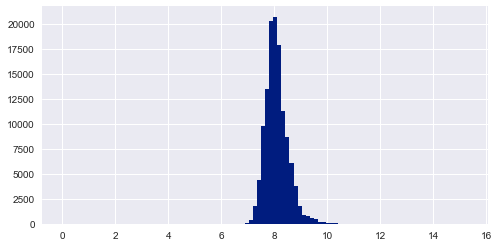

In [21]:
df['price_log'] = np.log(df.price.where(df.price>0))

df.price_log.hist(bins = 100, figsize=(8,4))

Threshold:  13000.0


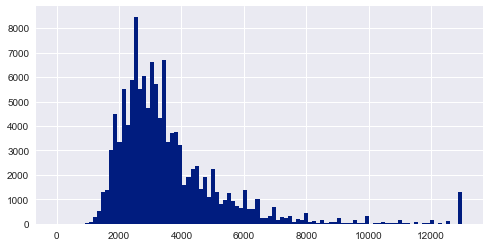

In [22]:
price_max = np.percentile(df.price, 99).tolist()
print "Threshold: ", price_max

df.price = np.where(df.price > price_max, price_max, df.price)

df.price.hist(bins = 100, figsize=(8,4))

### Target variable and its correlation within the others

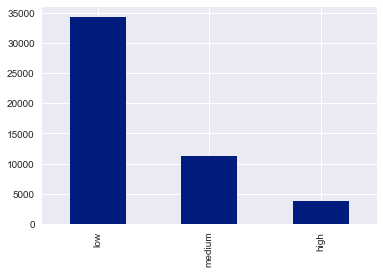

In [23]:
train_df.interest_level.value_counts().plot(kind='bar')

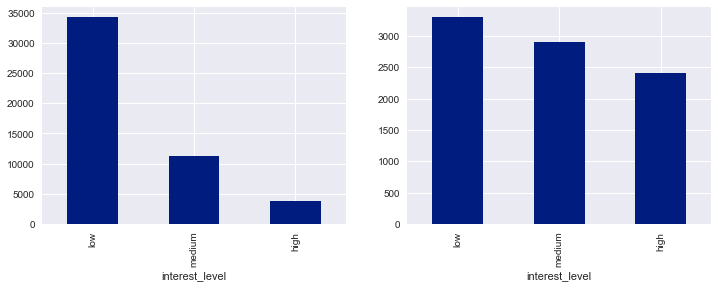

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

train_df.groupby('interest_level').price.count().reindex([u'low', u'medium', u'high']).plot(kind='bar', ax=axes[0])
train_df.groupby('interest_level').price.median().reindex([u'low', u'medium', u'high']).plot(kind='bar', ax=axes[1])

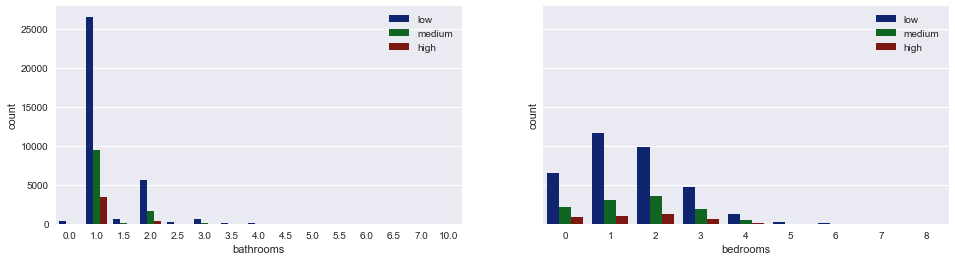

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

sns.countplot(x='bathrooms', hue='interest_level', data=train_df, hue_order=[u'low', u'medium', u'high'], ax=ax1).legend(loc=1).figure.set_size_inches(16,4)
sns.countplot(x='bedrooms', hue='interest_level', data=train_df, hue_order=[u'low', u'medium', u'high'], ax=ax2).legend(loc=1).figure.set_size_inches(16,4)

In [26]:
df.building_id.value_counts().head(10)

0                                   20664
96274288c84ddd7d5c5d8e425ee75027    705  
11e1dec9d14b1a9e528386a2504b3afc    546  
bb8658a3e432fb62a440615333376345    522  
80a120d6bc3aba97f40fee8c2204524b    510  
ce6d18bf3238e668b2bf23f4110b7b67    459  
f68bf347f99df026f4faad43cc604048    457  
c94301249b8c09429d329864d58e5b82    410  
ea9045106c4e1fe52853b6af941f1c69    397  
128d4af0683efc5e1eded8dc8044d5e3    385  
Name: building_id, dtype: int64

In [27]:
train_df.building_id.value_counts().head(10)

0                                   8286
96274288c84ddd7d5c5d8e425ee75027    275 
11e1dec9d14b1a9e528386a2504b3afc    215 
80a120d6bc3aba97f40fee8c2204524b    213 
bb8658a3e432fb62a440615333376345    212 
f68bf347f99df026f4faad43cc604048    191 
c94301249b8c09429d329864d58e5b82    167 
ce6d18bf3238e668b2bf23f4110b7b67    165 
57ef86c28a8ae482dc3a3c3af28e8e48    159 
128d4af0683efc5e1eded8dc8044d5e3    153 
Name: building_id, dtype: int64

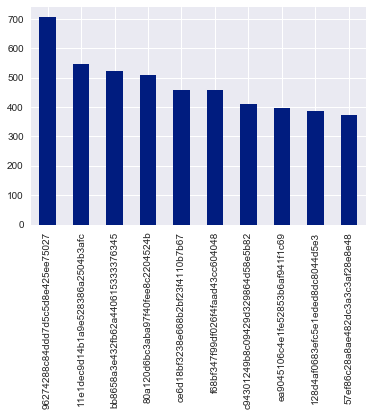

In [28]:
df.building_id.where(df.building_id != '0').value_counts().head(10).plot(kind='bar')

In [29]:
bldg_id_counts = df.building_id.value_counts()
df['listings_in_bldg'] = df.building_id.map(lambda b: bldg_id_counts[b] if b != '0' else 1)

In [30]:
df.manager_id.value_counts().head(10)

e6472c7237327dd3903b3d6f6a94515a    6387
6e5c10246156ae5bdcd9b487ca99d96a    1683
8f5a9c893f6d602f4953fcc0b8e6e9b4    1011
cb87dadbca78fad02b388dc9e8f25a5b    971 
62b685cc0d876c3a1a51d63a0d6a8082    956 
9df32cb8dda19d3222d66e69e258616b    862 
2aa9bfa5f67ed9997ea341dee8a3a271    853 
b7de4cb395920136663132057fa89d84    849 
ad3d8ddc52c7e0859b5c6c7f7949c3bd    732 
c9c33695ee2a2f818e9f1d8f7d1c4b39    731 
Name: manager_id, dtype: int64

In [31]:
df.manager_id.value_counts().tail(10)

947ae5d7d68d4e3dd500e60563065da7    1
799d6cf108cb6350e10eb2a4d77dc075    1
6e7b18d0e13c7d8ab2f25f19fc206f15    1
b3a3aae7392093169b83436f8491adc0    1
84a791745d2377d963f05ebf45bee94b    1
28f2ee59507afb3229af1cd81b9d1f08    1
0ead4ce211989abed5452c6d12cee62e    1
2e275003f2c453844267e2b8bf794f90    1
ab01d605707d7910288be73b9756d3aa    1
644412373f48247dbe136cedce607aab    1
Name: manager_id, dtype: int64

In [32]:
sf = df.manager_id.value_counts()
managers_df = pd.DataFrame({'manager_id':sf.index, 'cnt':sf.values})
managers_df.where(managers_df.cnt == 1).sum()

cnt   1,060
dtype: float64

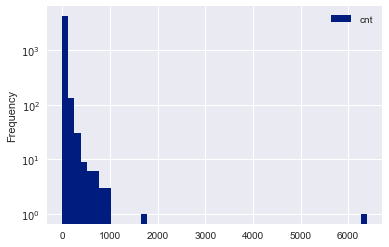

In [33]:
managers_df.plot(kind='hist', bins=50, log=True)

In [34]:
df['num_photos'] = df.photos.apply(len)
df['num_features'] = df.features.apply(len)
df['description_size'] = df.description.apply(lambda x: len(x.split(" ")))

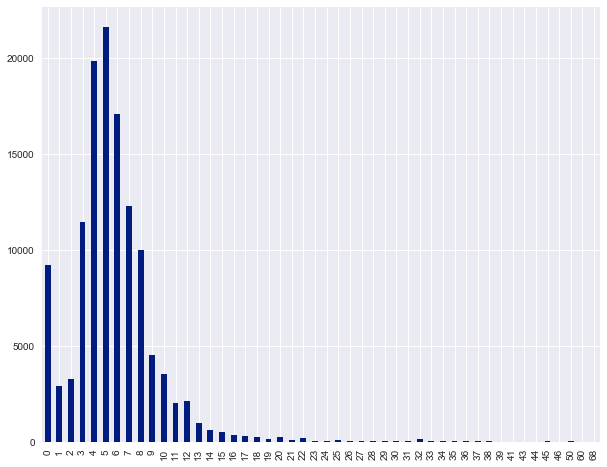

In [35]:
df.num_photos.value_counts().sort_index().plot(kind='bar', figsize=(10,8))

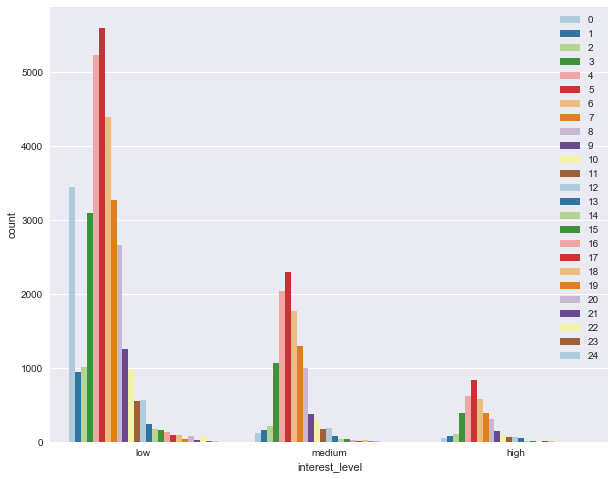

In [36]:
sns.countplot(x='interest_level', hue='num_photos', data=df[df.num_photos<25], order=[u'low', u'medium', u'high'], palette='Paired').legend(loc=1).figure.set_size_inches(10,8)

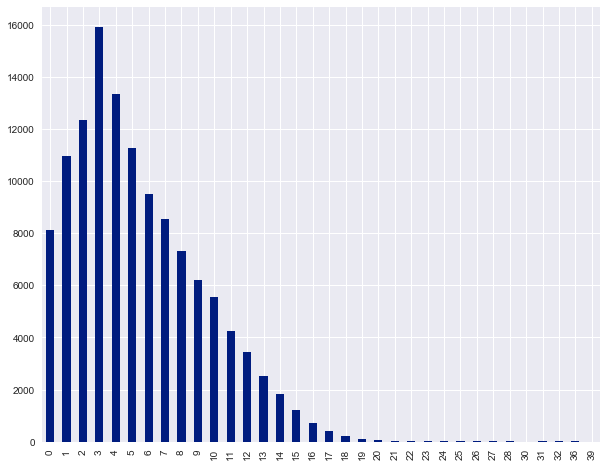

In [37]:
df.num_features.value_counts().sort_index().plot(kind='bar', figsize=(10,8))

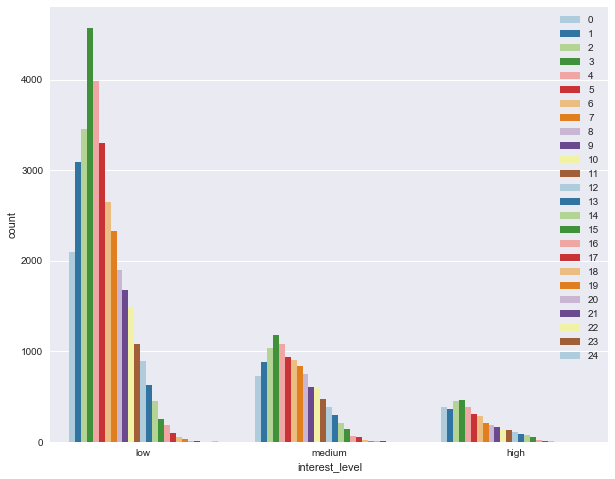

In [38]:
sns.countplot(x='interest_level', hue='num_features', data=df[df.num_features<25], order=[u'low', u'medium', u'high'], palette='Paired').legend(loc=1).figure.set_size_inches(10,8)

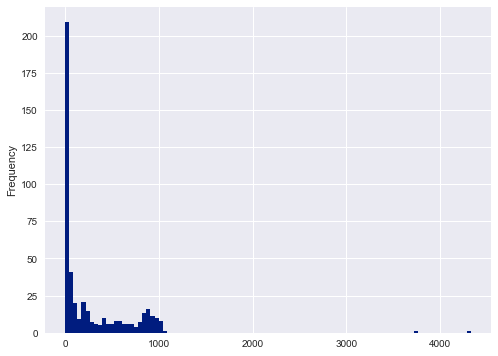

In [39]:
df.description_size.value_counts().sort_index().plot(kind='hist', bins=100, figsize=(8,6))

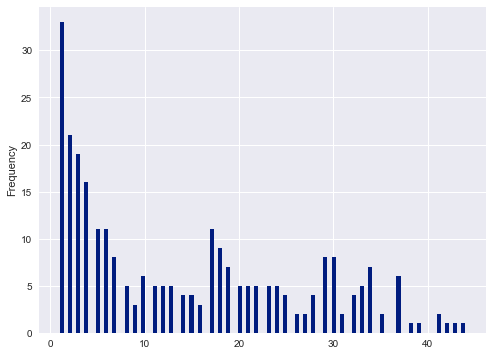

In [40]:
df[df.interest_level=='high'].description_size.value_counts().sort_index().plot(kind='hist', bins=100, figsize=(8,6))

In [41]:
df['month'] = df.created.dt.strftime('%b')
df['hod'] = df.created.dt.hour
df['dow'] = df.created.dt.strftime('%A')

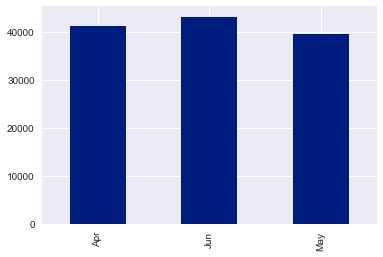

In [42]:
df.month.value_counts().sort_index().plot(kind='bar')

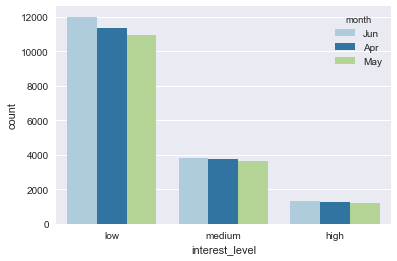

In [43]:
sns.countplot(x='interest_level', hue='month', data=df, order=[u'low', u'medium', u'high'], palette='Paired')

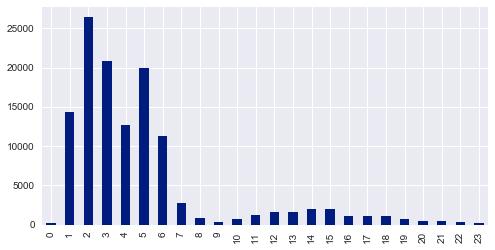

In [44]:
df.hod.value_counts().sort_index().plot(kind='bar', figsize=(8,4))

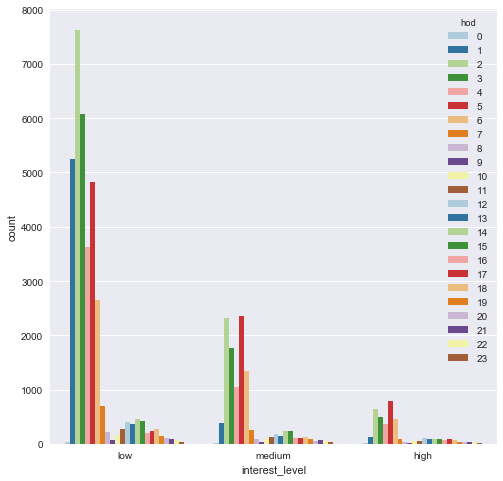

In [45]:
sns.countplot(x='interest_level', hue='hod', data=df, order=[u'low', u'medium', u'high'], palette='Paired').figure.set_size_inches(8,8)

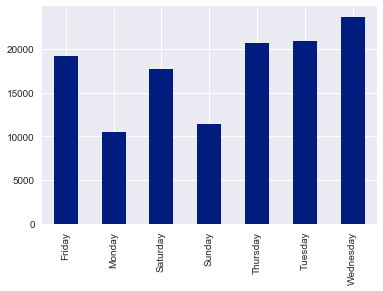

In [46]:
df.dow.value_counts().sort_index().plot(kind='bar')

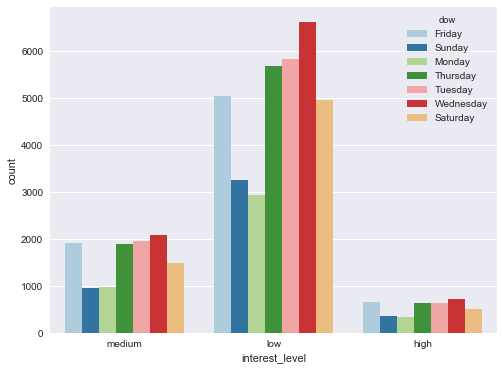

In [47]:
sns.countplot(x='interest_level', hue='dow', data=df, palette='Paired').figure.set_size_inches(8,6)

/Users/ikononenko/tensorflow/lib/python2.7/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
/Users/ikononenko/tensorflow/lib/python2.7/site-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


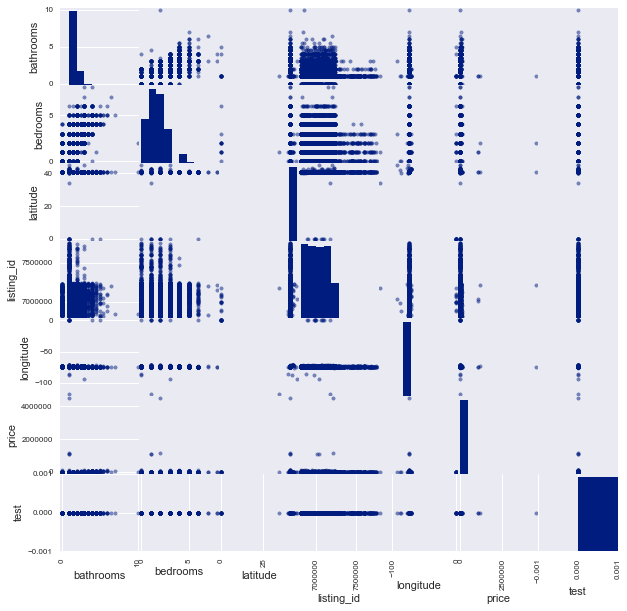

In [48]:
# Scatter Matrix
pd.scatter_matrix(train_df, figsize=(10, 10))
plt.show()

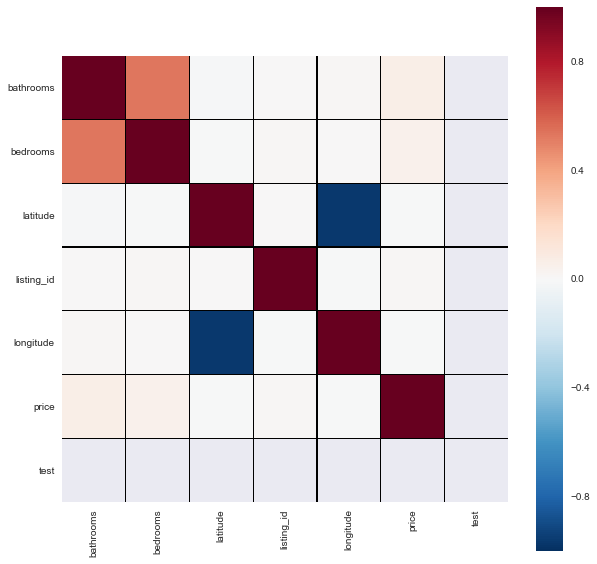

In [49]:
# Pearson Correlation Matrix
sns.heatmap(train_df.corr(), linewidths=0.25, vmax=1.0, square=True , linecolor='black').figure.set_size_inches(10,10)

### Listings location

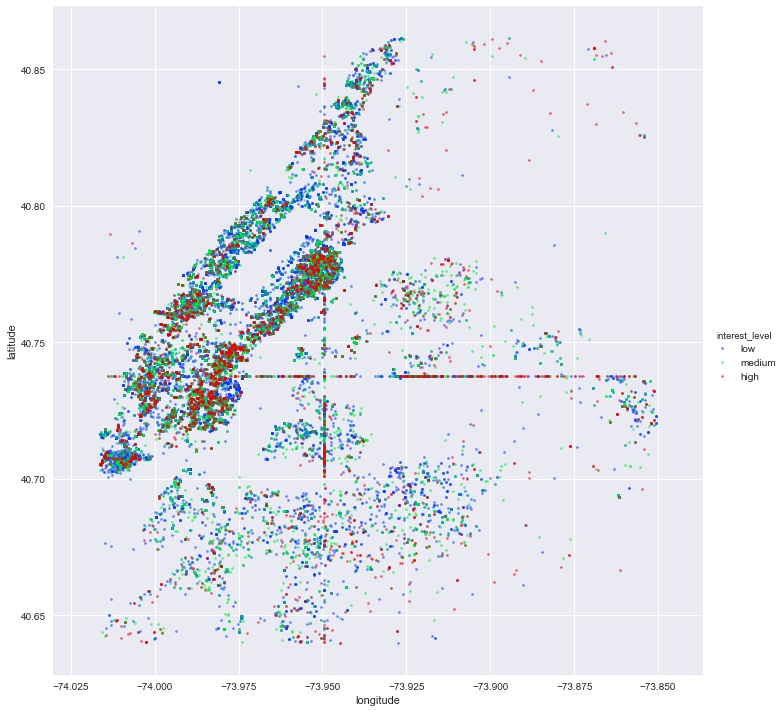

In [50]:
sns.lmplot(x='longitude', y='latitude', data=df, hue='interest_level', fit_reg=False, 
           scatter_kws={'alpha':0.6, 's':7}, size=10, hue_order=[u'low', u'medium', u'high'], palette='bright')

https://www.kaggle.com/shubh24/two-sigma-connect-rental-listing-inquiries/neighborhood-as-factor-reverse-geocoding - NOT ALLOWED in kaggle

In [51]:
# https://github.com/thampiman/reverse-geocoder
import reverse_geocoder as rg

In [52]:
train_coordinates = df[['listing_id', 'latitude', 'longitude']]

# Reverse Geocoder takes a list of tuples (of latitude and longitude) as its input.
lat_lon = []
listings = []

for i, j in train_coordinates.iterrows():
    lat_lon.append((j['latitude'], j['longitude']))
    listings.append(int(j['listing_id']))

In [53]:
results = rg.search(lat_lon)
# nbd = [[listings[i], results[i]['name']] for i in range(0, len(results))]

Loading formatted geocoded file...


In [54]:
for i in range(0, len(results)):
    df.loc[df['listing_id'] ==listings[i], 'neighborhood'] = results[i]['name']

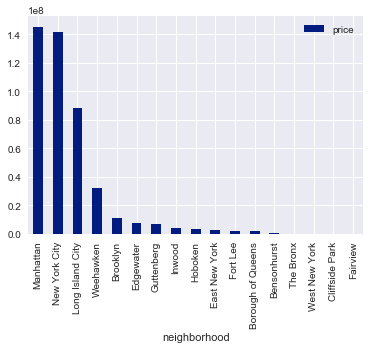

In [55]:
df.groupby('neighborhood').agg({'price':sum}).sort_values(by='price', ascending=False).plot(kind='bar')

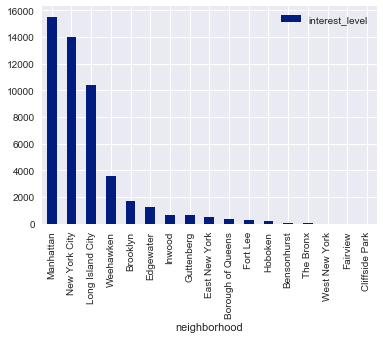

In [56]:
df.groupby('neighborhood').agg({'interest_level':'count'}).sort_values(by='interest_level', ascending=False).plot(kind='bar')

Instead of we could use the clustering algorithm to create the neighborhoods ourselves...

zips?

## Cleaning up character variables

### Addresses

In [57]:
df.display_address.value_counts().head(10)

Broadway             1163
East 34th Street     868 
Wall Street          853 
Second Avenue        838 
West 37th Street     722 
First Avenue         678 
West Street          649 
John Street          585 
Gold Street          572 
Washington Street    553 
Name: display_address, dtype: int64

In [58]:
df.street_address.value_counts().head(10)

3333 Broadway           449
505 West 37th Street    406
200 Water Street        369
90 Washington Street    336
100 Maiden Lane         332
100 John Street         314
401 East 34th Street    313
1 West Street           306
2 Gold Street           278
95 Wall Street          277
Name: street_address, dtype: int64

In [59]:
df[df.display_address.isin(df.street_address)==False][:3]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,price_per_bath,price_log,listings_in_bldg,num_photos,num_features,description_size,month,hod,dow,neighborhood
0,2,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy These Following Apartment Features As You Rent Here? Modern Designed Bathroom w/ a Deep Spa Soaking Tub? Room to Room AC/Heat? Real Oak Hardwood Floors? Rain Forest Shower Head? SS steel Appliances w/ Chef Gas Cook Oven & LG Fridge? washer /dryer in the apt? Cable Internet Ready? Granite Counter Top Kitchen w/ lot of cabinet storage spaceIt's Just A Few blocks To L Train<br /><br />Don't miss out!<br /><br />We have several great apartments in the immediate area.<br /><br />For additional information 687-878-2229<p><a website_redacted,Metropolitan Avenue,[],medium,41,7211212,...,"2,000",8,5,5,0,95,Jun,7,Friday,Long Island City
2,1,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-war building with laundry in the basement and live in super!<br/><br/>Apartment features a large bedroom with closet. Separate living room, kitchen features granite tops, dishwasher and microwave included, marble bathroom and hardwood flooring. Building is very well maintained and conveniently located near A,C,E,L,1,2,3 trains. Surrounded by many local cafe?s, restaurants, available for November 1st move in!<br/><br/>To view this apartment or any other please contact me via email or call at the number listed.<br/><br/><br/><br/><br/><br/>Bond New York is a real estate broker that supports equal housing opportunity.<p><a website_redacted",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Floors, Pets Allowed Case by Case]",high,41,6887163,...,"2,850",8,131,8,4,94,Apr,3,Sunday,New York City
3,1,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,"Building Amenities - Garage - Garden - fitness room - laundry room -rooftop deck .<br /><br />Located in midtown East - High energy area - plenty of Bars and restaurants to choose from - within walking distance to the transit E,M,6,7<br /><br />This Apartment also feature a renovated kitchen with microwave - Marble Bath tiles.<br /><br />Call or Email and Text for Exclusive Showing!!<br /><br />**NO FEE**<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><p><a website_redacted",East 49th Street,"[Hardwood Floors, No Fee]",low,41,6888711,...,"3,275",8,236,3,2,80,Apr,2,Monday,Long Island City


In [60]:
import unicodedata
import re

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii

In [61]:
df['display_address_ascii'] = [remove_accents(line) for line in df.display_address] 
df['street_address_ascii'] = [remove_accents(line) for line in df.street_address] 

In [62]:
pd.DataFrame(df['display_address_ascii'].unique()).to_csv('display_address_ascii.csv')
pd.DataFrame(df['street_address_ascii'].unique()).to_csv('street_address_ascii.csv')

In [63]:
def clean_addresses(df,column):
    return df['%s' % column].map(lambda x: ' '.join(x.strip('!@#$%^&*()-_+=;,./\\\'\t')\
                                                    .replace("'",'').lower()\
                                                    .replace(' street', ' st').replace(' avenue', ' ave')\
                                                    .replace(' road', ' rd').replace(' boulevard', ' blvd')\
                                                    .replace(' east', ' e').replace(' west', ' w')\
                                                    .replace('east ', 'e ').replace('west ', 'w ').split()))

In [64]:
df['display_address_clean'] = clean_addresses(df, 'display_address_ascii')
df.display_address_clean.value_counts()[:20]

broadway         1184
wall st          1131
e 34th st        1118
w st             1020
w 37th st        935 
john st          910 
second ave       900 
gold st          849 
york ave         782 
washington st    752 
lexington ave    733 
first ave        733 
columbus ave     707 
w 42nd st        694 
water st         685 
e 39th st        674 
e 35th st        618 
e 46th st        615 
thompson st      602 
w end ave        593 
Name: display_address_clean, dtype: int64

In [65]:
df['street_address_clean'] = clean_addresses(df, 'street_address_ascii')
df.street_address_clean.value_counts()[:20]

1 w st               533
505 w 37th st        512
200 water st         505
3333 broadway        455
90 washington st     455
100 john st          440
2 gold st            403
401 e 34th st        400
95 wall st           358
100 maiden lane      352
8 spruce st          322
95 christopher st    294
45 wall st           293
145 e 16th st        283
340 e 29th st        277
200 e 72nd st        273
50 w 34th st         267
116 john st          262
550 w 54th st        258
620 w 42nd st        248
Name: street_address_clean, dtype: int64

In [66]:
df = df.where(df.display_address_clean.isin(df.street_address_clean) == False).dropna()
df[['display_address_clean', 'street_address_clean']]

,display_address_clean,street_address_clean
0,metropolitan ave,792 metropolitan ave
3,e 49th st,333 e 49th st
4,w 143rd st,500 w 143rd st
5,w 18th st,350 w 18th st
6,w 107th st,210 w 107th st
8,hamilton terrace,63 hamilton terrace
11,w. 173rd st,644 w. 173rd st
13,w 63rd st,30 w 63rd st
15,e 34th st,340 e 34th st
16,1st ave,214 1st ave


In [67]:
str1 = 'metropolitan ave'
str2 = '792 metropolitan ave'

str1 in str2

True

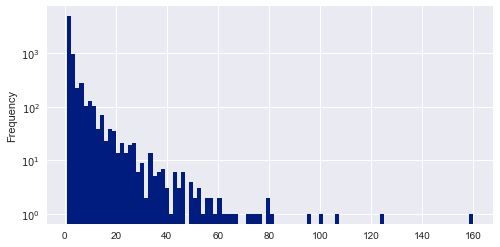

In [69]:
df.groupby('street_address_clean')['street_address_clean'].value_counts().plot(kind='hist', bins=100, log=True, figsize=(8,4))